In [108]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## Predicting churn

Our aim in this notebook is to build a model that can help us understand the true drivers of churn, and offer suggestions to retain customers.

We created a lot of categorical variables in the second notebook, but we will not use them here and instead try to build a few decision trees that will naturally identify adequate splits of features.

In [109]:
train = pd.read_parquet('data/training_3.pq')
test = pd.read_parquet('data/testing_3.pq')

In [110]:
# Exclude categorical features we had created, and only keep original features
org_feats = ['Age', 'Gender', 'Tenure', 'UsageFrequency','SupportCalls', 'PaymentDelay', 'SubscriptionType', 'ContractLength','TotalSpend', 'LastInteraction', 'Churn']

train_org = train[org_feats].copy()
test_org = test[org_feats].copy()

We encode the 3 original categorical features of our datasets by using an Ordinal encoder.
The indices of the labels in the categories array below are the actual encoding values (0, 1, and 2). 

In [111]:
from sklearn.preprocessing import OrdinalEncoder

categories = [['Male','Female'],
          ['Standard','Basic','Premium'],
          ['Monthly', 'Quarterly','Annual']]

enc = OrdinalEncoder(categories=categories)

feats = ['Gender','SubscriptionType','ContractLength']

train_org[feats] = enc.fit_transform(train_org[feats])
test_org[feats] = enc.fit_transform(test_org[feats])

Let's recheck we did not re-introduce NA values.

In [112]:
test_org.isna().sum()

Age                 0
Gender              0
Tenure              0
UsageFrequency      0
SupportCalls        0
PaymentDelay        0
SubscriptionType    0
ContractLength      0
TotalSpend          0
LastInteraction     0
Churn               0
dtype: int64

In [113]:
train_org.isna().sum()

Age                 0
Gender              0
Tenure              0
UsageFrequency      0
SupportCalls        0
PaymentDelay        0
SubscriptionType    0
ContractLength      0
TotalSpend          0
LastInteraction     0
Churn               0
dtype: int64

Now that all features are numeric, let's also check feature collinearity.

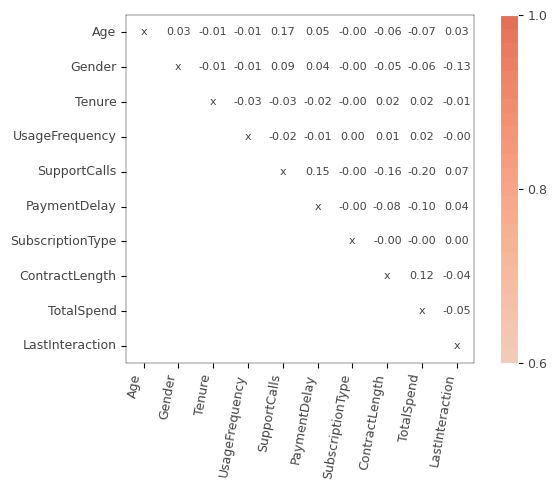

In [157]:
### Feature Collinearity
from rfpimp import plot_corr_heatmap
viz = plot_corr_heatmap(train_org, figsize=(7,5))
viz.save('./corrheatmap.svg')

There is no particular collinearity to report.

Let's keep preparing our datasets for the modelling phase, by separating the predicted variable ("Churn"), from the set of predictors.

In [114]:
y_test = test_org.pop('Churn')
y_train = train_org.pop('Churn')

In [115]:
train_org[100:105]

,Age,Gender,Tenure,UsageFrequency,SupportCalls,PaymentDelay,SubscriptionType,ContractLength,TotalSpend,LastInteraction
100,32.0,0.0,13.0,6.0,4.0,11.0,1.0,2.0,649.0,8.0
101,38.0,1.0,3.0,11.0,5.0,16.0,0.0,1.0,212.0,4.0
102,60.0,0.0,50.0,10.0,2.0,4.0,0.0,1.0,552.0,8.0
103,48.0,0.0,4.0,7.0,9.0,29.0,0.0,1.0,421.0,4.0
104,52.0,1.0,1.0,29.0,2.0,19.0,1.0,2.0,202.0,22.0


In [136]:
# proportion of churners in test set
test.Churn.sum()/test.Churn.count()

0.47370710413074213

It is straightforward to train multiple classifiers on the training set alone, using a cross-validation procedure.

We do so below, by training on 90% of the training set and predicting the remaining 10%, in a round-robbin fashion. We select a Random Forest Classifier with low complexity for each individual tree (maximum depth of 3). 

In [116]:
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, max_depth = 3, random_state=12)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, train_org, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Accuracy: 0.960 (0.001)


As you can see, this average cross-validated accuracy is very high (96%), but we should refit the model on the entire training set and see how it is performing on the test data.


In [117]:
from sklearn.metrics import accuracy_score

model.fit(train_org, y_train)
y_pred = model.predict(test_org)
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

0.5437697099625608


Accuracy drops quite a bit, to 54.37%! 

Let's see which features seem important by using a method based on features permutation (more reliable that scikit-learn's default).

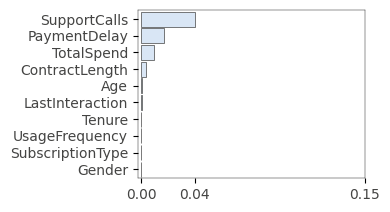

In [118]:
from rfpimp import *
imp = importances(model, test_org, y_test) # permutation
viz = plot_importances(imp)
viz.view()

In [119]:
imp

,Importance
Feature,
SupportCalls,0.0358
PaymentDelay,0.0152
TotalSpend,0.0086
ContractLength,0.0034
Age,0.0008
LastInteraction,0.0006
Tenure,0.0000
UsageFrequency,0.0000
SubscriptionType,0.0000


This provides a first hint regarding potential drivers of churn, by decreasing order of importance:
- Support Calls
- Payment Delays
- Total Spend
- Age and Contract Length

Because our model is an ensemble of 100 decision trees, it is impractical to come up with a unified understanding of those drivers and the threshold at which they take meaning.

For that reason, we will now train a single decision tree of depth 3, in a bootstrapped fashion against the test set. It is usually not ideal to use the test set in that specific way, but it is a trade-off we are making to produce a potentially more actionable model.

In [87]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import ConfusionMatrixDisplay

max_acc = 0
# bootstrap 3000 times by using different random seeds
for rs in range(3000):
    rfc = RandomForestClassifier(n_estimators=1, max_depth = 3, random_state=rs)
    rfc.fit(train_org, y_train)
    y_pred = rfc.predict(test_org)
    accuracy = accuracy_score(y_test, y_pred)
    if accuracy >= max_acc:
        # output the seed for which we have the highest accuracy on the test set so far
        max_acc = accuracy
        print(rs, accuracy)

0 0.5851858756272235
2 0.6064066116729583
3 0.6081309906634975
5 0.6174208882882043
6 0.6668996908545773
14 0.6929517950629942
172 0.6978919078467012
322 0.7151201628062326
374 0.7249382485902036
430 0.7258082055584036


## Focus on model 1

This model has a very high accuracy of 72.58% on the test set. Let's refit it, and look at detailed metrics.

In [138]:
rfc = RandomForestClassifier(n_estimators=1, max_depth = 3, random_state=430)
rfc.fit(train_org, y_train)
y_pred = rfc.predict(test_org)

In [139]:
cm = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

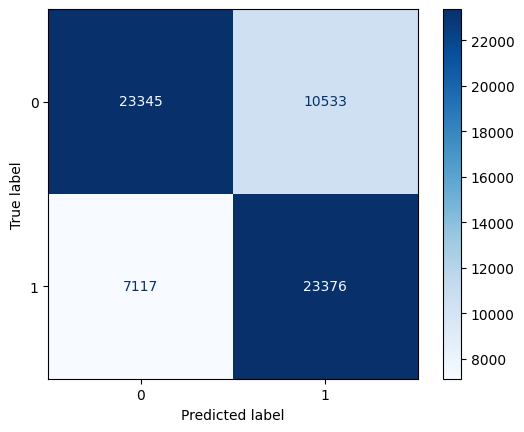

In [140]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap = 'Blues')
plt.show()

In [141]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.69      0.73     33878
           1       0.69      0.77      0.73     30493

    accuracy                           0.73     64371
   macro avg       0.73      0.73      0.73     64371
weighted avg       0.73      0.73      0.73     64371



In [142]:
print("Accuracy  : ", accuracy)
print("Precision : ", precision)
print("Recall    : ", recall)
print("F1-Score  : ", f1)

Accuracy  :  0.7258082055584036
Precision :  0.6893745023445103
Recall    :  0.7666021709900633
F1-Score  :  0.7259401881929132


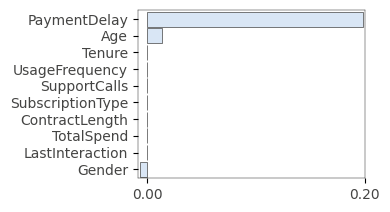

In [143]:
from rfpimp import *

imp = importances(rfc, test_org, y_test) # permutation
viz = plot_importances(imp)
viz.view()

In [144]:
imp

,Importance
Feature,
PaymentDelay,0.1990
Age,0.0138
Tenure,0.0000
UsageFrequency,0.0000
SupportCalls,0.0000
SubscriptionType,0.0000
ContractLength,0.0000
TotalSpend,0.0000
LastInteraction,0.0000


We can now visualize that single decision tree and translate it in a first potential retention action.

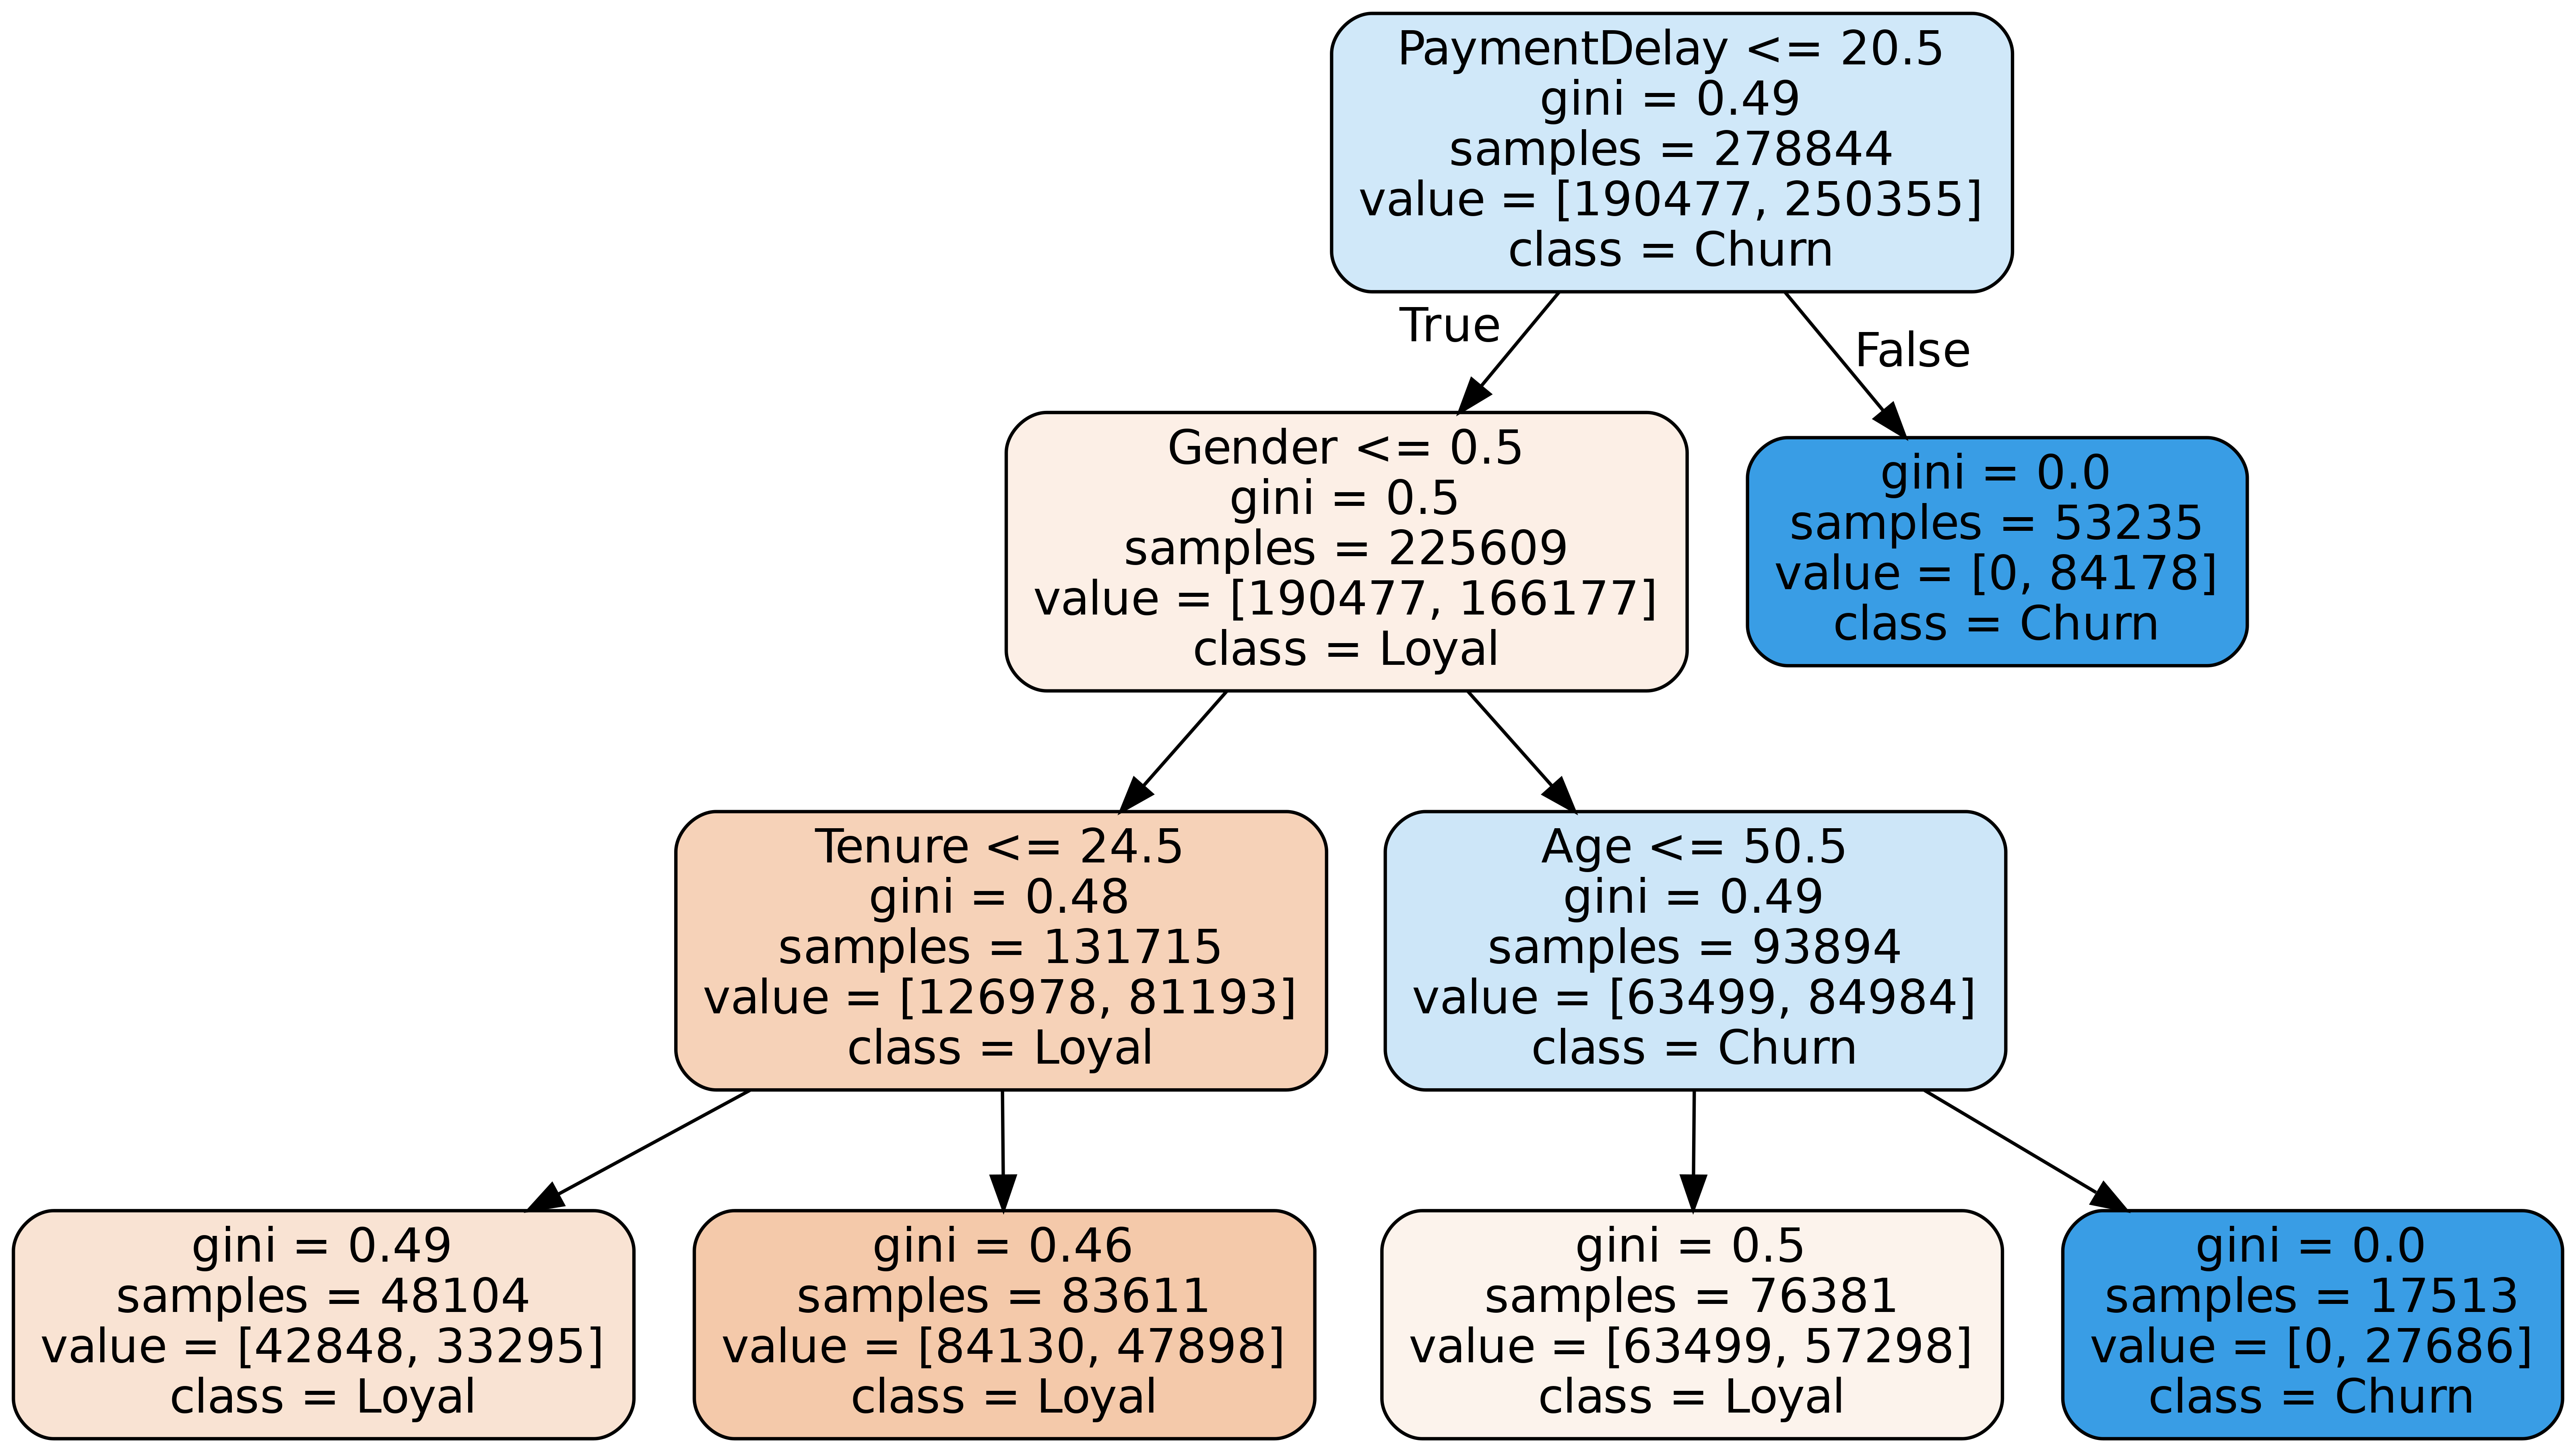

In [145]:
from sklearn.tree import export_graphviz

estimator = rfc.estimators_[0]

export_graphviz(estimator, 
                out_file='model1.dot', 
                feature_names = test_org.columns,
                class_names = ["Loyal","Churn"],
                rounded = True, proportion = False, 
                precision = 2, filled = True)

from subprocess import call
call(['dot', '-Tpng', 'model1.dot', '-o', 'model1.png', '-Gdpi=600'])

from IPython.display import Image
Image(filename = 'model1.png')

#### Suggested action 

Implement a retention campaign that focuses on retaining customers with 21 or more payment delays. Otherwise, focus on retaining women of age 51 and above.

## Focus on model 2

This model also has a very high accuracy of 72.49% on the test set. Let's refit it, and look at detailed metrics.

In [147]:
rfc = RandomForestClassifier(n_estimators=1, max_depth = 3, random_state=374)
rfc.fit(train_org, y_train)
y_pred = rfc.predict(test_org)

In [148]:
cm = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

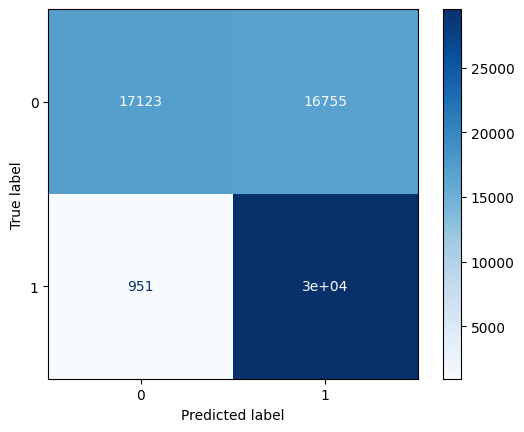

In [149]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap = 'Blues')
plt.show()

In [150]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.51      0.66     33878
           1       0.64      0.97      0.77     30493

    accuracy                           0.72     64371
   macro avg       0.79      0.74      0.71     64371
weighted avg       0.80      0.72      0.71     64371



In [151]:
print("Accuracy  : ", accuracy)
print("Precision : ", precision)
print("Recall    : ", recall)
print("F1-Score  : ", f1)

Accuracy  :  0.7249382485902036
Precision :  0.638097500917986
Recall    :  0.9688125143475552
F1-Score  :  0.7694231019664017


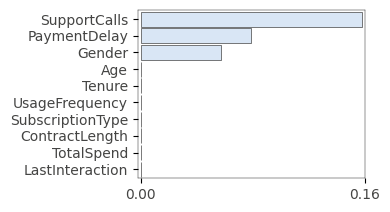

In [152]:
from rfpimp import *

imp = importances(rfc, test_org, y_test) # permutation
viz = plot_importances(imp)
viz.view()

In [153]:
imp

,Importance
Feature,
SupportCalls,0.1558
PaymentDelay,0.0776
Gender,0.0568
Age,0.0000
Tenure,0.0000
UsageFrequency,0.0000
SubscriptionType,0.0000
ContractLength,0.0000
TotalSpend,0.0000


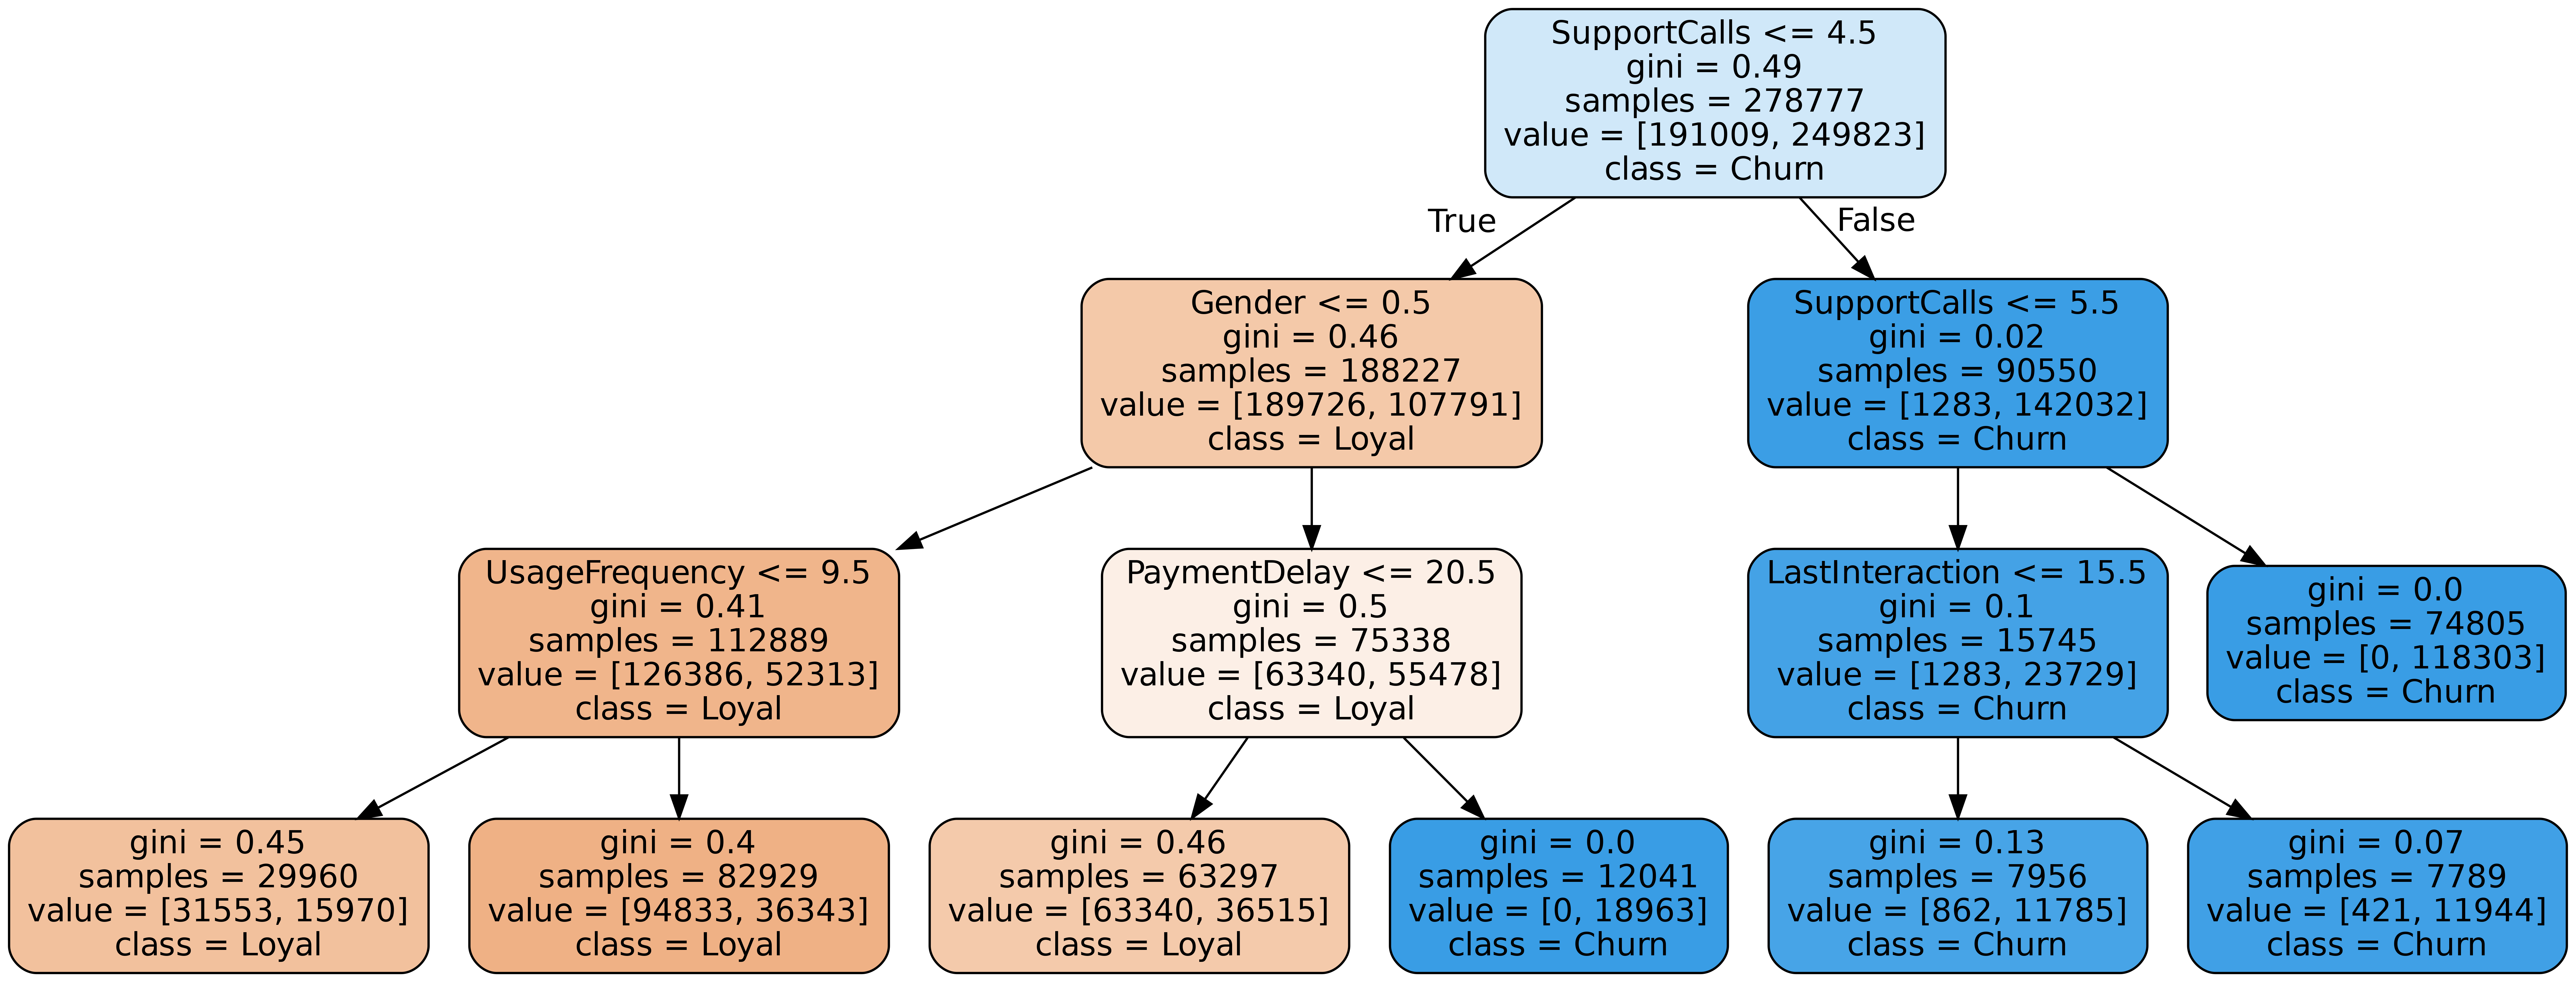

In [154]:
from sklearn.tree import export_graphviz

estimator = rfc.estimators_[0]

export_graphviz(estimator, 
                out_file='model2.dot', 
                feature_names = test_org.columns,
                class_names = ["Loyal","Churn"],
                rounded = True, proportion = False, 
                precision = 2, filled = True)

from subprocess import call
call(['dot', '-Tpng', 'model2.dot', '-o', 'model2.png', '-Gdpi=600'])

from IPython.display import Image
Image(filename = 'model2.png')

#### Suggested action

Implement a retention campaign that focuses on retaining customers with 5 support calls or more. Otherwise, for those with 4 Support calls or less, focus on retaining Women with 21 payment delays or more.

### Which model is really best?

We used accuracy as a measure of performance, and model 1 does better than model 2 by a very thin margin. One other important metric to look is the F1 score, and model 2 has a notably higher score (76.94) than model 1 (72.59). This means model 2 offers a beter balance of precision and recall. 

Let's dive even further in their respective merits:
- model 2 does an outstanding job at capturing a large fraction of the churners (97% of them - that's recall), but in doing so there is 1 chance in 3 you will actually end up talking to a loyal customer (that's 64% precision). 
- model 1 captures a lot less churners (77% of them), while only marginally improving its precision (69%), and so you'd have 3 chances in 10 to be talking to a loyal customer when you think you are talking to a churner.

At the end of the day, model 2 seems like a better choice, due to its almost perfect coverage of our intended target (churners), and a an associated pay-off that is likely to exceed the consequences of having slightly lesser precision (one such consequence could be that, if a loyal customer gets a retention phone call, they might realize their plan was not as competitive as they thought, and it might incite them to do a more comprehensive round of competitive analysis by shopping around, and maybe churn, which was the opposite objective of the campaign!)